Heat equation in one spatial dimension:
$$\frac{\partial T}{\partial t} = \alpha \frac{\partial ^2 T}{\partial x^2}$$

Where $\alpha$ is the thermal diffusivity and $T$ is the temperature.

Implicit works differently than what we used.  It will use more data from the "future" in the update including several values of $T$ at $t^{n+1}$.  It will make the scheme more difficult to apply.

## Implicit Schemes

Combine Euler time step with an evaluation of the spatial derivative on the updated solution at $t^{n+1}$.  Discretized gives:

$$\frac{T_i ^{n+1} - T_i ^n}{\Delta t} = \alpha \frac{T_{i+1} ^{n+1} - 2T_i ^{n+1} + T_{i-1} ^{n+1}}{\Delta x^2}$$

From the previous time step we only know $T_i ^n$ but what about $T_i ^{n+1}$, $T_{i-1} ^{n+1}$ and $T_{i+1} ^{n+1}$

Put what we know on the RHS and what we don't know on the LHS, which gives:

$$-T_{i-1} ^{n+1} + \left( 2 + \frac{\Delta x^2}{\alpha \Delta t} \right) T_i ^{n+1} - T_{i+1} ^{n+1} = T_i ^n \frac{\Delta x^2}{\alpha \Delta t}$$

What does it look like with $i = 1$?

$$-T_0 ^{n+1} + \left( 2 + \frac{\Delta x^2}{\alpha \Delta t} \right) T_1 ^{n+1} - T_2 ^{n+1} = T_1 ^n \frac{\Delta x^2}{\alpha \Delta t}$$

and $i = 2$?

$$-T_1 ^{n+1} + \left( 2 + \frac{\Delta x^2}{\alpha \Delta t} \right) T_2 ^{n+1} - T_3 ^{n+1} = T_2 ^n \frac{\Delta x^2}{\alpha \Delta t}$$

What about $i = 3$?

$$-T_2 ^{n+1} + \left( 2 + \frac{\Delta x^2}{\alpha \Delta t} \right) T_3 ^{n+1} - T_4 ^{n+1} = T_3 ^n \frac{\Delta x^2}{\alpha \Delta t}$$

Common element for these 3 at least $T_2 ^{n+1}$

### Boundary Conditions??

The value of $T_0 ^{n+1}$ is known at every time-step from the BC.  All unknown terms on the LHS and known on the RHS for $i = 1$:

$$-T_2 ^{n+1} + \left( 2 + \frac{\Delta x^2}{\alpha \Delta t} \right) T_1 ^{n+1} = T_1 ^n \frac{\Delta x^2}{\alpha \Delta t} + T_0 ^{n+1}$$

For $i = N - 2$:

$$-T_{N-3} ^{n+1} + \left( 2 + \frac{\Delta x^2}{\alpha \Delta t} \right) T_{N-2} ^{n+1} - T_{N-1} ^{n+1} = T_{N-2} ^n \frac{\Delta x^2}{\alpha \Delta t}$$

Discretized Neumann BC on the RHS of the rod is:

$$\frac{T_{N-1} ^n - T_{N-2} ^n}{\Delta x} = q$$

We can easily write that at time step $n + 1$(the boundary conditions apply at every time-step):

$$\frac{T_{N-1} ^{n+1} - T_{N-2} ^{n+1}}{\Delta x} = q$$

Inserting the Neumann BC in the equation for $i = N - 2$ gives:

$$-T_{N-3} ^{n+1} + \left( 1 + \frac{\Delta x^2}{\alpha \Delta t} \right) T_{N-2} ^{n+1} = T_{N-2} ^n \frac{\Delta x^2}{\alpha \Delta t} + \Delta xq$$

Now the linear system of eqs in matrix form are:

$$[A][x] = [b] + [b]_{b.c.}$$

Where the matrix of coefficients $[A]$ is a sparse matrix.

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
# Initial conditions
L = 1.
nt = 100
nx = 51.
alpha = 1.22e-3

q = 0.

dx = L / (nx - 1)

qdx = q * dx

Ti = numpy.zeros(nx)
Ti[0] = 100

/Users/Michael/Applications/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Solving a linear system

Need to solve a linear sys of equations above to advance the solution in time.  Can use SciPy which has linear solvers.

From scipy.linalg we can improve **solve**

**solve**: Function that solves linear systems

In [3]:
from scipy.linalg import solve

In [4]:
def generateMatrix(N, sigma):
    """Computes the matrix for the diffusion equation with backward Euler Dirichlet condition at i=0, Neumann at i=-1
    
    Parameters:
    ----------
    T : array of float
        Temperature at current time step
    sigma : float
        alpha * dt / dx ^ 2
        
    Returns:
    -------
    A : 2D numpy array of float
        Matrix for diffusion equation
    """
    
    # Set up the diagonal
    d = numpy.diag(numpy.ones(N-2) * (2 + 1. / sigma))
    
    # Consider Neumann BC
    d[-1, -1] = 1 + 1. / sigma
    
    # Setup upper diagonal
    ud = numpy.diag(numpy.ones(N - 3) * -1, 1)
    
    # Setup lower diagonal
    ld = numpy.diag(numpy.ones(N - 3) * -1, -1)
    
    A = d + ud + ld
    
    return A

In [5]:
def generateRHS(T, sigma, qdx):
    """Computes right-hand side of linear system for diffusion equation with backward Euler
    
    Parameters:
    ----------
    T : array of float
        Temperature at current time step
    sigma : float
        alpha * dt / dx ^ 2
    qdx : float
        flux at right boundary * dx
        
    Returns:
    -------
    b : array of float
        Right-hand side of diffusion equation with backward Euler
    """
    
    b = numpy.zeros_like(T)
    
    b = T[1:-1] * 1. / sigma
    
    # Consider Dirichlet BC
    b[0] += T[0]
    
    # Consider Neumann BC
    b[-2] += qdx
    
    return b

In [6]:
def implicit_ftcs(T, A, nt, sigma, qdx):
    """Advances diffusion equation in time with implicit central scheme
    
    Parameters:
    ----------
    T : array of float
        initial temperature profile
    A : 2D array of float
        Matrix with discretized diffusion equation
    nt : int
        number of time steps
    sigma : float
        alpha * dt / dx ^2
    qdx : float
        flux at right boundary * dx
    
    Returns:
    -------
    T : array of floats
        temperature profile after nt time steps
    """
    
    for t in range(nt):
        Tn = T.copy()
        b = generateRHS(Tn, sigma, qdx)
        # Use numpy.linalg.solve
        T_interior = solve(A,b)
        T[1:-1] = T_interior
        # Enforce Neumann BC (Dirichlet is enforced automatically)
        T[-1] = T[-2] + qdx
        
    return T
        

In [7]:
#Solves the lin sys for every time step but matrix A doesn't change. You can only generate it once and then use it as an input parameters to the time stepping function

sigma = 0.5
dt = sigma * dx * dx / alpha
nt = 1000

A = generateMatrix(nx , sigma)

In [8]:
print(A)

[[ 4. -1.  0. ...,  0.  0.  0.]
 [-1.  4. -1. ...,  0.  0.  0.]
 [ 0. -1.  4. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  4. -1.  0.]
 [ 0.  0.  0. ..., -1.  4. -1.]
 [ 0.  0.  0. ...,  0. -1.  3.]]


In [9]:
T = implicit_ftcs(Ti.copy(), A, nt, sigma, qdx)

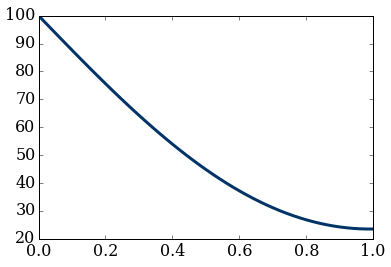

In [10]:
pyplot.plot(numpy.linspace(0, 1, nx), T, color = '#003366', ls = '-', lw = 3);

Looks like the explicit forward in time centered in space for $\alpha \frac{\Delta t}{\Delta x^2} = \frac{1}{2}$

Lets try at $\alpha \frac{\Delta t}{\Delta x^2} = 5$ which violates the stability condition of the explicit scheme